In [1]:
#import ML4PS as ml
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os

%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '..')
import ML4PS as ml

# Loading and preprocessing the data

In [3]:
data_dir = '../data/data_json/case14'
normalizer = ml.Normalizer(data_dir = data_dir, backend_name = 'pandapower')
interface = ml.Interface(data_dir = data_dir, backend_name = 'pandapower', batch_size = 1)

Loading all the dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.50it/s]


# Defining a Hyper Heterogeneous Multi Graph Neural Ordinary Differential Equation (H2MGNODE)
The H2MGNODE combines the Hyper Heterogeneous Multi Graph Neural Network and Neural Ordinary Differential Equations.

It uses an architecture very similar to the H2MGNN architecture, but it solves the latent system of equations using a variable timestep method. Contrarily to the fully connected, you do not have to specify the amount of objects of each class at the initialization. It will take as input both the addresses $a$ and the features $x$. One should tell the H2MGNODE which addresses it should be using to propagate information.

In [4]:
addresses = {}
addresses['bus']       = ['id']
addresses['gen']       = ['bus']
addresses['load']      = ['bus']
addresses['shunt']     = ['bus']
addresses['ext_grid']  = ['bus']
addresses['line']      = ['from_bus', 'to_bus']
addresses['trafo']     = ['hv_bus', 'lv_bus']
addresses['poly_cost'] = ['element']

input_features = {}
input_features['bus']       = ['in_service', 'max_vm_pu', 'min_vm_pu', 'vn_kv']
input_features['load']      = ['const_i_percent', 'const_z_percent', 'controllable', 'in_service', 
                               'p_mw', 'q_mvar', 'scaling', 'sn_mva']
input_features['gen']       = ['in_service', 'p_mw', 'scaling', 'sn_mva', 'slack', 'max_p_mw', 
                               'min_p_mw', 'max_q_mvar', 'min_q_mvar', 'slack_weight']
input_features['shunt']     = ['q_mvar', 'p_mw', 'vn_kv', 'step', 'max_step', 'in_service']
input_features['ext_grid']  = ['in_service', 'va_degree', 'max_p_mw', 'min_p_mw', 'max_q_mvar',
                               'min_q_mvar', 'slack_weight']
input_features['line']      = ['c_nf_per_km', 'df', 'g_us_per_km', 'in_service', 'length_km', 'max_i_ka',
                               'max_loading_percent', 'parallel', 'r_ohm_per_km', 'x_ohm_per_km']
input_features['trafo']     = ['df', 'i0_percent', 'in_service', 'max_loading_percent', 'parallel', 
                               'pfe_kw', 'shift_degree', 'sn_mva', 'tap_max', 'tap_neutral', 'tap_min', 
                               'tap_phase_shifter', 'tap_pos', 'tap_side', 'tap_step_degree', 
                               'tap_step_percent', 'vn_hv_kv', 'vn_lv_kv', 'vk_percent', 'vkr_percent']
input_features['poly_cost'] = ['cp0_eur', 'cp1_eur_per_mw', 'cp2_eur_per_mw2', 'cq0_eur', 
                               'cq1_eur_per_mvar', 'cq2_eur_per_mvar2']

actor_output_features = {}
actor_output_features['gen'] = ['mu_vm_pu']
actor_output_features['ext_grid'] = ['mu_vm_pu']

critic_output_features = {}
critic_output_features['line'] = ['res_pl_mw']
critic_output_features['trafo'] = ['res_pl_mw']
critic_output_features['bus'] = ['res_vm_pu']

In [5]:
actor = ml.H2MGNODE(addresses=addresses, 
                       input_features = input_features, 
                       output_features = actor_output_features, 
                       hidden_dimensions = [32], 
                       latent_dimension = 16)
critic = ml.H2MGNODE(addresses=addresses, 
                       input_features = input_features, 
                       output_features = critic_output_features, 
                       hidden_dimensions = [32], 
                       latent_dimension = 16)

In [6]:
actor_postproc_functions = {
    'gen': {'mu_vm_pu': [ml.AffineTransform(offset=1., slope=1.)]},
    'ext_grid': {'mu_vm_pu': [ml.AffineTransform(offset=1., slope=1.)]},
}
actor_postproc = ml.PostProcessor(functions=actor_postproc_functions)

critic_postproc_functions = {
    'line': {'res_pl_mw': [ml.AffineTransform(slope=1.), ml.AbsValTransform()]},
    'trafo': {'res_pl_mw': [ml.AffineTransform(slope=1.), ml.AbsValTransform()]},
    'bus': {'res_vm_pu': [ml.AffineTransform(offset=1., slope=1.)]},
}
critic_postproc = ml.PostProcessor(functions=critic_postproc_functions)

In [7]:
import jax.numpy as jnp


def joule(y):
    line_pl_mw = jnp.sum(jnp.sum(y['line']['res_pl_mw'], axis=2), axis=1)
    trafo_pl_mw = jnp.sum(jnp.sum(y['trafo']['res_pl_mw'], axis=2), axis=1)
    return line_pl_mw + trafo_pl_mw

def voltage(x,y):
    bus_vm_pu_max = jnp.sum(jnp.sum(jnp.maximum(0, y['bus']['res_vm_pu'] - x['bus']['max_vm_pu']), axis=2), axis=1)
    bus_vm_pu_min = jnp.sum(jnp.sum(jnp.maximum(0, x['bus']['min_vm_pu'] - y['bus']['res_vm_pu']), axis=2), axis=1)    
    return bus_vm_pu_max + bus_vm_pu_min

def cost_function(x, z, lam):
    cost_joule_line = interface.joule_losses(active_power_losses=z['line']['res_pl_mw'])
    cost_joule_trafo = interface.joule_losses(active_power_losses=z['trafo']['res_pl_mw'])
    cost_voltage = interface.voltage_deviation(vm_pu=y['bus']['res_vm_pu'], vm_pu_max=None, vm_pu_min=None)
    return cost_voltage + lam *cost_joule

def cost_actor(x, y_actor, y_critic, z, lam, sigma):
    baseline = ell(x, y_critic)
    reward = ell(x,z, lam)
    delta = reward - baseline
    loss_gen = jnp.sum(jnp.sum((z['gen']['vm_pu'] - y_actor['gen']['mu_vm_pu'])**2, axis=2), axis=1)
    loss_ext_grid = jnp.sum(jnp.sum((z['ext_grid']['vm_pu'] - y_actor['ext_grid']['mu_vm_pu'])**2, axis=2), axis=1)
    loss = delta * (loss_gen + loss_ext_grid) / (2 * sigma**2)
    return - jnp.mean(loss)
    
def cost_critic(y_critic, z, lam):
    loss_line_pl_mw = (y_critic['line']['res_pl_mw'] - z['line']['res_pl_mw'])**2
    loss_line_pl_mw = jnp.sum(jnp.sum(loss_line_pl_mw, axis=2), axis=1)
    
    loss_trafo_pl_mw = (y_critic['trafo']['res_pl_mw'] - z['trafo']['res_pl_mw'])**2
    loss_trafo_pl_mw = jnp.sum(jnp.sum(loss_trafo_pl_mw, axis=2), axis=1)
    
    loss_bus_vm_pu = (y_critic['bus']['res_vm_pu'] - z['bus']['res_vm_pu'])**2
    loss_bus_vm_pu = jnp.sum(jnp.sum(loss_bus_vm_pu, axis=2), axis=1)
    
    loss = loss_bus_vm_pu + lam * (loss_line_pl_mw + loss_trafo_pl_mw)
    return jnp.mean(loss)

In [8]:
def loss_actor(params, init_state, y, r, r_critic, sigma):
    beta_raw = actor.solve_and_decode_batch(params, init_state)
    beta = actor_postproc(beta_raw)
    loss_gen = jnp.sum(jnp.sum((y['gen']['vm_pu'] - beta['gen']['mu_vm_pu'])**2, axis=2), axis=1)
    loss_ext_grid = jnp.sum(jnp.sum((y['ext_grid']['vm_pu'] - beta['ext_grid']['mu_vm_pu'])**2, axis=2), axis=1)
    delta = jnp.sum(jnp.array(r) - jnp.array(r_critic), axis=1)
    loss = delta * (loss_gen + loss_ext_grid) / (2 * sigma**2)
    return jnp.mean(loss)

@ml.jit
def update_actor_diff(step, params, init_state, y, r, r_critic, sigma, actor_opt_state):
    value, grads = ml.value_and_grad(loss_actor)(params, init_state, y, r, r_critic, sigma)
    actor_opt_state = actor_opt_update(step, grads, actor_opt_state)
    return actor_get_params(actor_opt_state), actor_opt_state, value

def update_actor(step, params, a, x, y, r, r_critic, sigma, opt_state):
    x_norm = normalizer(x)
    init_state = actor.init_state_batch(a, x_norm)
    params, opt_state, loss = update_actor_diff(step, params, init_state, y, r, r_critic, sigma, opt_state)
    return params, opt_state, loss


def loss_critic(params, init_state, x, z, lam, sigma):
    y_critic_raw = critic.solve_and_decode_batch(params, init_state)
    y_critic = critic_postproc(y_critic_raw)
    
    loss_line_pl_mw = (y_critic['line']['res_pl_mw'] - z['line']['res_pl_mw'])**2
    loss_line_pl_mw = jnp.sum(jnp.sum(loss_line_pl_mw, axis=2), axis=1)
    
    loss_trafo_pl_mw = (y_critic['trafo']['res_pl_mw'] - z['trafo']['res_pl_mw'])**2
    loss_trafo_pl_mw = jnp.sum(jnp.sum(loss_trafo_pl_mw, axis=2), axis=1)
    
    loss_bus_vm_pu = (y_critic['bus']['res_vm_pu'] - z['bus']['res_vm_pu'])**2
    loss_bus_vm_pu = jnp.sum(jnp.sum(loss_bus_vm_pu, axis=2), axis=1)
    
    loss = loss_bus_vm_pu + lam * (loss_line_pl_mw + loss_trafo_pl_mw)
    return jnp.mean(loss)

@ml.jit
def update_critic_diff(step, params, init_state, x, z, lam, sigma, critic_opt_state):
    value, grads = ml.value_and_grad(loss_critic)(params, init_state, x, z, lam, sigma)
    critic_opt_state = critic_opt_update(step, grads, critic_opt_state)
    return critic_get_params(critic_opt_state), critic_opt_state, value

def update_critic(step, params, a, x, z, lam, sigma, opt_state):
    x_norm = normalizer(x)
    init_state = critic.init_state_batch(a, x_norm)
    params, opt_state, loss = update_critic_diff(step, params, init_state, x, z, lam, sigma, opt_state)
    return params, opt_state, loss

In [9]:
actor_step_size = 1e-3
actor_opt_init, actor_opt_update, actor_get_params = ml.optimizers.adam(actor_step_size)
actor_opt_state = actor_opt_init(actor.weights)

critic_step_size = 1e-2
critic_opt_init, critic_opt_update, critic_get_params = ml.optimizers.adam(critic_step_size)
critic_opt_state = critic_opt_init(critic.weights)

step = 0

In [10]:
from tqdm.notebook import tqdm

sigma = 0.001
lam1 = 1e-3

joule_list = []
voltage_list = []
critic_list = []

In [11]:
def reward_batch(network_batch, converged_batch, lam1, lam2):
    joule_batch = interface.joule_effect_batch(network_batch, converged_batch)
    voltage_batch = interface.voltage_deviation_batch(network_batch, converged_batch)
    overflow_batch = interface.overflow_percentage_batch(network_batch, converged_batch)
    r_batch = []
    for jw, vw, ow, cw in zip(joule_batch, voltage_batch, overflow_batch, converged_batch):
        r_window = []
        for j, v, o, c in zip(jw, vw, ow, cw):
            if c:
                r_window.append(1/(j + lam1*v + lam2*o))
            else:
                r_window.append(0.)
        r_batch.append(r_window)
    return r_batch

def apply_action(network_batch, y, lam1=1., lam2=1.):
    interface.update_network_batch(network_batch, y)
    converged_batch = interface.run_load_flow_batch(network_batch)
    r_batch = reward_batch(network_batch, converged_batch, lam1, lam2)
    return r_batch

def sample_action(beta, sigma=1.):
    gen_vm_pu = np.random.normal(beta['gen']['mu_vm_pu'], sigma)
    ext_grid_vm_pu = np.random.normal(beta['ext_grid']['mu_vm_pu'], sigma)
    return {'gen': {'vm_pu': gen_vm_pu}, 'ext_grid': {'vm_pu': ext_grid_vm_pu}}

def explore(a, x, nets, sigma=1., lam1=1., lam2=1.):

    # Normalize input data
    x_norm = normalizer(x)
    
    # Sample an action using the actor, and compute a loadflow
    beta_raw = actor.forward_batch(actor.weights, a, x_norm)
    beta = actor_postproc(beta_raw)
    y = sample_action(beta, sigma)
    r = apply_action(nets, y, lam1, lam2)
    
    # Estimate the reward using the critic
    #r_critic_raw = critic.forward_batch(critic.weights, a, x_norm)
    #r_critic = critic_postproc(r_critic_raw)
    y_critic = sample_action(beta, sigma=0.)
    r_critic = apply_action(nets, y_critic, lam1, lam2)
    
    return y, r, r_critic

In [12]:
a, x, nets = next(iter(interface.train))


In [13]:
r_list = []
y_list = []
for _ in range(1000):
    y, r, r_critic = explore(a, x, nets, sigma=1e-2)
    r_list.append(r[0][0])
    y_list.append(y['gen']['vm_pu'][0,0,0])

KeyboardInterrupt: 

In [ ]:
T = 1000

plt.scatter(y_list[:T], r_list[:T])
plt.show()
print(np.cov(y_list[:T], r_list[:T])[0,1])

In [ ]:
y['gen']['vm_pu'][0,0,0]

In [16]:
r_list = []

In [ ]:
for epoch in range(5):
    train_pbar = tqdm(interface.train)
    for a, x, nets in train_pbar:
        

        step +=1

        y, r, r_critic = explore(a, x, nets, sigma=1e-4, lam1=1e4, lam2=0.)
        r_list.append(np.mean(r))

        actor.weights, actor_opt_state, actor_loss = update_actor(
            step, actor.weights, a, x, y, r, r_critic, sigma, actor_opt_state)

        #critic.weights, critic_opt_state, critic_loss = update_critic(
        #    step, critic.weights, a, x, z, lam, sigma, critic_opt_state)

        # Store rewards and display scores
        #r_joule = float(jnp.mean(joule(z) * lam))
        #joule_list.append(r_joule)
        #r_voltage = float(jnp.mean(voltage(x,z)))
        #voltage_list.append(r_voltage)
        #loss_critic = cost_critic(y_critic, z, lam)
        #critic_list.append(loss_critic)
        train_pbar.set_description("Epoch {}, Reward = {:.2e}".format(epoch, np.mean(r)))



  0%|          | 0/6983 [00:00<?, ?it/s]

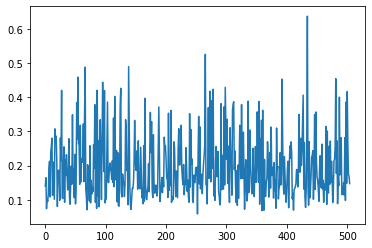

In [29]:
plt.plot(r_list)
plt.show()

In [30]:
y

{'gen': {'vm_pu': array([[[1.04346367],
          [1.02474306],
          [1.04140667],
          [1.04120169]]])},
 'ext_grid': {'vm_pu': array([[[1.06006682]]])}}

In [23]:
r, r_critic

([[0.17592808922630326]], [[0.17590156674040802]])

In [24]:
x['bus']['max_vm_pu']

array([[[1.06],
        [1.06],
        [1.06],
        [1.06],
        [1.06],
        [1.06],
        [1.06],
        [1.06],
        [1.06],
        [1.06],
        [1.06],
        [1.06],
        [1.06],
        [1.06]]])

In [25]:
apply_action(nets, y, lam1=1e2, lam2=0.)

[[0.17592808922630326]]

In [26]:
nets[0][0].res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.056304,0.000000,-139.890747,-10.559183
1,1.037887,-2.753342,-29.348097,1.276805
2,1.020058,-7.700488,53.636061,-8.486552
3,1.012523,-6.614216,43.282865,-3.471734
4,1.012810,-5.563051,7.657853,1.826307
5,1.033437,-9.451956,10.055360,15.605836
6,1.036298,-8.669213,0.000000,0.000000
7,1.030816,-8.669213,0.000000,3.208053
8,1.040780,-9.744408,11.539120,-13.794194
9,1.034107,-10.031580,9.155059,3.257567


In [27]:
interface.backend.voltage_deviation(nets[0][0], True)

0.0

In [ ]:
interface.backend.joule_effect(nets[0][0], True)

In [ ]:
interface.backend.overflow_percentage(nets[0][0], True)

In [ ]:
plt.plot(joule_list)
plt.show()

plt.plot(voltage_list)
plt.show()

plt.plot(critic_list)
plt.show()

In [ ]:
voltage(x, z)

In [ ]:
voltage(x, y_critic)

In [ ]:
y_critic

In [ ]:
z['gen']['vm_pu']

In [ ]:
x['bus']['max_vm_pu']

In [ ]:
plt.scatter(y_actor['gen']['mu_vm_pu'], z['gen']['vm_pu'])

In [ ]:
l_c

In [ ]:
line_pl_mw = jnp.sum(jnp.sum(z['line']['res_pl_mw'], axis=2), axis=1)
trafo_pl_mw = jnp.sum(jnp.sum(z['trafo']['res_pl_mw'], axis=2), axis=1)
bus_vm_pu_max = jnp.sum(jnp.sum(jnp.maximum(0, z['bus']['res_vm_pu'] - x['bus']['max_vm_pu']), axis=2), axis=1)
bus_vm_pu_min = jnp.sum(jnp.sum(jnp.maximum(0, x['bus']['min_vm_pu'] - z['bus']['res_vm_pu']), axis=2), axis=1)    
bus_vm_pu_max

In [ ]:
import matplotlib.pyplot as plt

start_and_end_times = ml.linspace(0., 1., 50)

def odenet(params, init_state):
    intermediate_states = ml.odeint(actor.dynamics, init_state, start_and_end_times, params)
    return intermediate_states

batched_odenet = ml.vmap(odenet, in_axes=(None, 0))
    
a, x, nets = next(iter(interface.test))
x_norm = normalizer(x)
init_state = actor.init_state_batch(a, x_norm)
intermediate_states = batched_odenet(actor.weights, init_state)

y_plot = intermediate_states['h_e']['gen'][0,:,:,0]
plt.plot(start_and_end_times, y_plot)
plt.show()

x_plot = intermediate_states['h_e']['gen'][0,:,:,0]
y_plot = intermediate_states['h_e']['gen'][0,:,:,2]
plt.plot(x_plot, y_plot)
plt.show()

y_plot = intermediate_states['h_v'][0,:,:,0]
plt.plot(start_and_end_times, y_plot)
plt.show()

x_plot = intermediate_states['h_v'][0,:,:,0]
y_plot = intermediate_states['h_v'][0,:,:,1]
plt.plot(x_plot, y_plot)
plt.show()

y_plot = intermediate_states['h_g'][0,:,:,0]
plt.plot(start_and_end_times, y_plot)
plt.show()

x_plot = intermediate_states['h_g'][0,:,:,0]
y_plot = intermediate_states['h_g'][0,:,:,1]
plt.plot(x_plot, y_plot)
plt.show()

In [ ]:
y_plot = intermediate_states['h_g'][:,:,0,0].T
plt.plot(start_and_end_times, y_plot)
plt.show()

In [ ]:
intermediate_states['h_g'].shape

In [ ]:
plt.plot(train_losses)

In [ ]:
np.random.normal([1, 1], 0.0005)

In [ ]:
# Remove temporary data file
if os.path.isfile('test.hdf5'): os.remove('test.hdf5')

In [ ]:
import pandapower as pp

In [ ]:
nets[0][0].res_line.loading_percent

In [ ]:
(np.maximum(0, nets[0][0].res_bus.vm_pu - nets[0][0].bus.max_vm_pu)**2).sum()